In [243]:
import tensorflow as tf
import imageio
import os
import time
import PIL
import numpy as np
from tensorflow.keras import layers
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline

print(tf.__version__)
print(imageio.__version__)

2.6.0
2.9.0


In [244]:
cifar10 = tf.keras.datasets.cifar10

(train_x, _), (test_x, _) = cifar10.load_data()

train_x.shape
# print('max: ', train_x.max())
# print('min: ', train_x.min())

(50000, 32, 32, 3)

In [245]:
# 이미지 -1 ~ 1 정규화

train_x = (train_x -127.5) / 127.5
print('max: ', train_x.max())
print('min: ', train_x.min())

max:  1.0
min:  -1.0


In [246]:
train_x = train_x.reshape(train_x.shape[0], 32, 32, 3).astype('float32')
train_x.shape

(50000, 32, 32, 3)

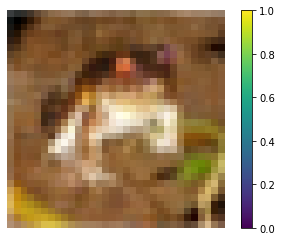

In [247]:
# -1과 1의 정규화를 하면, 시각화되지 않으므로 0과 1 로 변경

red_channel = (train_x[0, :, :, 0] + 1) / 2  # Red 채널
green_channel = (train_x[0, :, :, 1] + 1) / 2  # Green 채널
blue_channel = (train_x[0, :, :, 2] + 1) / 2  # Blue 채널

just_check = np.dstack((red_channel, green_channel, blue_channel))

plt.imshow(just_check)
plt.colorbar()
plt.axis('off') # 크기 표시 축 제거
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

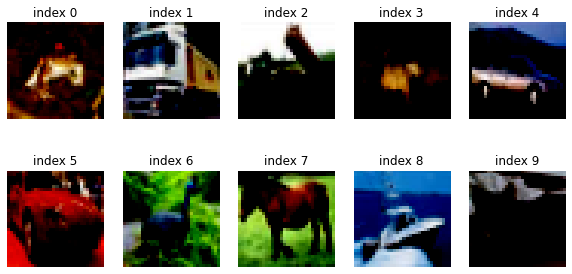

In [248]:
plt.figure(figsize = (10, 5))

for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(train_x[i], cmap = 'gray') # 오류 발생, 
# 0과 1 값이 아니므로 Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
# 원본 색깔의 이미지가 출력되고 gray스케일? 하려면 위와 같이 0과 1 값으로 변경해줘야함
    plt.title(f'index {i}')
    plt.axis('off')
plt.show()

In [249]:
# 전체 데이터를 섞고, 미니 배치 구성하기

BUFFER_SIZE = 50000
BATCH_SIZE = 128
train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

#### 학습이 너무 오래 걸릴 경우 한 종류의 데이터만 추출해도 좋을 때 쓰는 레퍼런스 코드

def load_data(label=None):


    (train_x, train_y), (test_x, test_y) = tf.keras.datasets.cifar10.load_data()

    if label:
    
        df = pd.DataFrame(list(zip(train_x, train_y)), columns=['image', 'label']) 
        
        df = df[df['label']==label]
        
        train_x = np.array([i for i in list(df['image'])])
        
        df = pd.DataFrame(list(zip(test_x, test_y)), columns =['image', 'label']) 
        
        df = df[df['label']==label]
        
        test_x = np.array([i for i in list(df['image'])])
    
    return train_x, test_x

## Step 3. 생성자 모델 구현하기

In [250]:
def make_generator_model_conv2d_T():
    # 모델 쌓기 시작하는 박스 추가
    model = tf.keras.Sequential()
    
    # 첫번째 Dense 층 생성
    model.add(layers.Dense(units = 4*4*256, use_bias = False, input_shape = (100, ))) # 4*4*256, 편향을 추가하지 않으므로 4*4*256 * 100개의 파라미터가 존재
    # 필터 수를 변경하면 파라미터의 크기가 달라져서 나중에 나올 판별자와 맞지 않아지므로 파라미터 고려해서 필터 크기 설정
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    # Dense가 아닌 다른 방식으로 쌓기 위한 reshape 층 생성
    model.add(layers.Reshape((4, 4, 256)))
    
    # 두번째 (reshape층 제외) Conv2D_T층 생성
    model.add(layers.Conv2DTranspose(filters = 128, kernel_size = (5, 5), strides = (2, 2), padding = 'same', use_bias = False,
                                    activation = 'tanh'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    # 세번째 Conv2D_T층 생성
    model.add(layers.Conv2DTranspose(filters = 64, kernel_size = (5, 5), strides = (2, 2), padding = 'same', use_bias = False,
                                    activation = 'tanh'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    # 네번째 Conv2D_T층 생성
    model.add(layers.Conv2DTranspose(filters = 3, kernel_size = (5, 5), strides = (2, 2), padding = 'same', use_bias = False,
                                    activation = 'tanh'))
    return model

In [251]:
generator = make_generator_model_conv2d_T()
generator.summary()

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_21 (Dense)             (None, 4096)              409600    
_________________________________________________________________
batch_normalization_15 (Batc (None, 4096)              16384     
_________________________________________________________________
leaky_re_lu_43 (LeakyReLU)   (None, 4096)              0         
_________________________________________________________________
reshape_7 (Reshape)          (None, 4, 4, 256)         0         
_________________________________________________________________
conv2d_transpose_12 (Conv2DT (None, 8, 8, 128)         819200    
_________________________________________________________________
batch_normalization_16 (Batc (None, 8, 8, 128)         512       
_________________________________________________________________
leaky_re_lu_44 (LeakyReLU)   (None, 8, 8, 128)       

In [252]:
# 랜덤한 노이즈 입력, 랜덤 이미지 생성
noise = tf.random.normal([1, 100])

In [253]:
generated_image = generator(noise, training = False)
generated_image.shape

TensorShape([1, 32, 32, 3])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


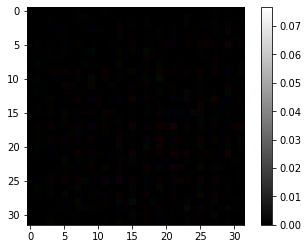

In [254]:
# red_channel_1 = (generated_image[0, :, :, 0]+1 )/2
# green_channel_1 = (generated_image[0, :, :, 1]+1)/2
# blue_channel_1 = (generated_image[0, :, :, 2]+1)/2

# just_check_1 = np.dstack((red_channel_1, green_channel_1, blue_channel_1))

plt.imshow(tf.squeeze(generated_image), cmap='gray') # squeeze, 이미지의 크기를 (1, 64, 64, 3)에서 (64, 64, 3)으로 반환 (크기가 1인 차원 제거)
plt.colorbar()
plt.show()

# 안된거 같은데 매트릭스 같은 뭔가가 잠깐잠깐 보임

## 판별자 모델 구현하기

In [255]:
def make_discriminator_model():
    # 시작 박스 설정
    model = tf.keras.Sequential()
    
    # 첫번째 Conv2D Layer
    model.add(layers.Conv2D(filters = 64, kernel_size = (5, 5), strides = (2, 2), padding = 'same', input_shape = (32, 32, 3)))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    # 두번째 Conv2D Layer
    model.add(layers.Conv2D(filters = 128, kernel_size = (5,5), strides = (2, 2), padding = 'same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    # 세번째 평탄층
    model.add(layers.Flatten())
    
    # 네번째 완전연결층
    model.add(layers.Dense(1))
    
    return model

In [256]:
discriminator = make_discriminator_model()
discriminator.summary()

Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_28 (Conv2D)           (None, 16, 16, 64)        4864      
_________________________________________________________________
leaky_re_lu_46 (LeakyReLU)   (None, 16, 16, 64)        0         
_________________________________________________________________
dropout_28 (Dropout)         (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 8, 8, 128)         204928    
_________________________________________________________________
leaky_re_lu_47 (LeakyReLU)   (None, 8, 8, 128)         0         
_________________________________________________________________
dropout_29 (Dropout)         (None, 8, 8, 128)         0         
_________________________________________________________________
flatten_14 (Flatten)         (None, 8192)            

In [257]:
decision = discriminator(generated_image, training = False)
decision

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[-0.00444702]], dtype=float32)>

## 손실함수와 최적화 함수 구현하기

In [258]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True) # .reduce_mean(tf.keras.losses.binary_crossentropy(....))를 사용해도 됨

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def discriminator_accuracy(real_output, fake_output):
    real_accuracy = tf.reduce_mean(tf.cast(tf.math.greater_equal(real_output, tf.constant([0.5])), tf.float32))
    fake_accuracy = tf.reduce_mean(tf.cast(tf.math.less(fake_output, tf.constant([0.5])), tf.float32))
    return real_accuracy, fake_accuracy

# 최적화 함수

generator_optimizer = tf.keras.optimizers.Adam(2e-4) # 0.0001도 많이 씀
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4)

In [259]:
noise_dim = 100
num_examples_to_generate = 16 # 16개의 고정 시드를 받음

seed = tf.random.normal([num_examples_to_generate, noise_dim])
seed.shape

TensorShape([16, 100])

In [260]:
@tf.function
def train_step(images): 
    noise = tf.random.normal([BATCH_SIZE, noise_dim]) 
    
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training = True)
        
        real_output = discriminator(images, training = True)
        fake_output = discriminator(generated_images, training = True)
        
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)
        
        real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output)
        
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    
    return gen_loss, disc_loss, real_accuracy, fake_accuracy

In [267]:
# 일정 간격으로 학습 현황 확인 샘플 함수 생성
def generate_and_save_images(model, epoch, it, sample_seeds):
    
    predictions = model(sample_seeds, training = False)
    
    predictions = (predictions + 1) / 2.0 # tanh를 사용하려고 -1과 1로 정규화 하니까 에러 발생, 0과 1 사이의 값이 필요
    
    fig = plt.figure(figsize = (4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i]) # RGB 컬러라 수정을 해야할 것 같은데 어떻게 해야할지
        plt.colorbar()
        plt.axis('off')
        
    plt.savefig(os.path.join(os.getenv('HOME'), 'aiffel', 'dcgan_newimage', 'cifar10', 'generated_samples',
                         'sample_epoch_{:04d}_iter_{:03d}.png'.format(epoch, it)))
    
    plt.show()

In [268]:
from matplotlib.pyplot import rcParams
rcParams['figure.figsize'] = 15, 6

def draw_train_history(history, epoch):
    plt.subplot(211)
    plt.plot(history['gen_loss'])
    plt.plot(history['disc_loss'])
    plt.title('model loss')
    plt.xlabel('loss')
    plt.ylabel('batch iters')
    plt.legend(['gen_loss', 'disc_loss'], loc = 'upper left')
    
    plt.subplot(212)
    plt.plot(history['fake_accuracy'])
    plt.plot(history['real_accuracy'])
    plt.title('model accuracy')
    plt.xlabel('accuracy')
    plt.ylabel('batch iters')
    plt.legend(['fake_accuracy', 'real_accuracy'], loc = 'upper left')
    
    plt.savefig('{}/aiffel/dcgan_newimage/cifar10/training_history/train_history_{:04d}.png'
               .format(os.getenv('HOME'), epoch))
    plt.show()

In [269]:
checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/training_checkpoints'

checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(generator_optimizer = generator_optimizer,
                                discriminator_optimizer = discriminator_optimizer,
                                generator = generator,
                                discriminator = discriminator)

In [273]:
def train(dataset, epochs, save_every):
    start = time.time()
    history = {'gen_loss': [], 'disc_loss':[], 'real_accuracy': [], 'fake_accuracy': []}
    
    for epoch in range(epochs):
        epoch_start = time.time()
        for it, image_batch in enumerate(dataset):
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step(image_batch)
            history['gen_loss'].append(gen_loss)
            history['disc_loss'].append(disc_loss)
            history['real_accuracy'].append(real_accuracy)
            history['fake_accuracy'].append(fake_accuracy)
            
            if it % 50 == 0:
                display.clear_output(wait=True)
                generate_and_save_images(generator, epoch+1, it+1, seed)
                print('Epoch {} | iter {}'.format(epoch+1, it+1))
                print('Time for epoch {}: {} sec'.format(epoch+1, int(time.time()-epoch_start)))
                
        if (epoch + 1) % save_every == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)
            
        display.clear_output(wait=True)
        generate_and_save_images(generator, epochs, it, seed)
        print('Time for training : {} sec'.format(int(time.time()-start)))
        
        draw_train_history(history, epoch)

In [274]:
save_every = 10
EPOCHS = 150

tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

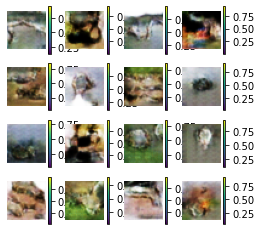

Time for training : 3972 sec


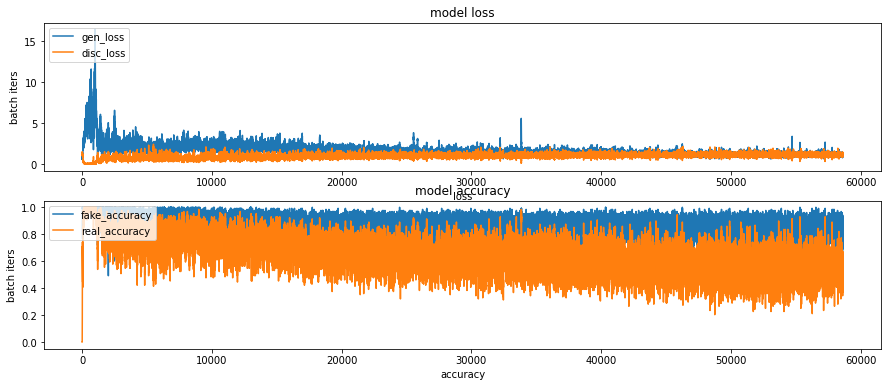

CPU times: user 52min 50s, sys: 5min 25s, total: 58min 16s
Wall time: 1h 6min 16s


In [275]:
%%time
train(train_dataset, EPOCHS, save_every)

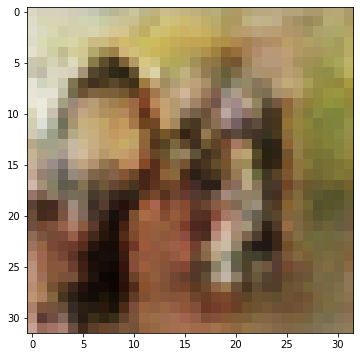

In [276]:
## checkpoint 모듈을 사용해서 모델 저장해가지고 재학습할 필요 없게 로드하기

checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/training_checkpoints'

latest = tf.train.latest_checkpoint(checkpoint_dir)
checkpoint.restore(latest)

generator = checkpoint.generator
discriminator = checkpoint.discriminator

# 로드한 모델이 정상적으로 이미지를 생성하는지 확인해 봅니다. 
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

np_generated = generated_image.numpy()
np_generated = (np_generated * 127.5) + 127.5   # reverse of normalization
np_generated = np_generated.astype(int)
plt.imshow(np_generated[0])
plt.show()  # 정상적으로 모델이 로드되었다면 랜덤 이미지가 아니라 CIFAR-10 이미지가 그려질 것입니다.

천천히 늘려보아야 하지만 시간이 없어 초기 학습량(epoch)을 많이 설정하면서 성능을 높이기 위한 방법으로 제일 만만한 것만 같아 150회로 늘렸고, 추가로 뭔가를 해야한다면

중간에 생성자 레이어 층을 늘려보거나,초기 파라미터 값을 많이 줘보거나 하는 등의 과정이 추가 된다면 개선할 수도 있을 것 같다